In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import learning_curve, LearningCurveDisplay, train_test_split, KFold, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
import matplotlib.pyplot as plt

## 1. Preprocessing

1. Cleaning up the data
2. Visualising data distribution
3. Converting the SMILES to Morgan Fingerprints

In [2]:
df = pd.read_csv('directing_groups_final.csv')

### 1.1. Cleaning up the data

In [3]:
# Same molecule can be represented by different SMILES strings, depending on the generating method.
# Canonicalizing the SMILES ensures same algorithm is used to generate the SMILES.

df['smiles'] = df['smiles'].apply(Chem.CanonSmiles)

In [4]:
# To ensure the model is not evaluated on training data, duplicates were removed

df.drop_duplicates(subset=['smiles'], inplace=True, ignore_index=True)

### 1.2. Visualizing the data distribution

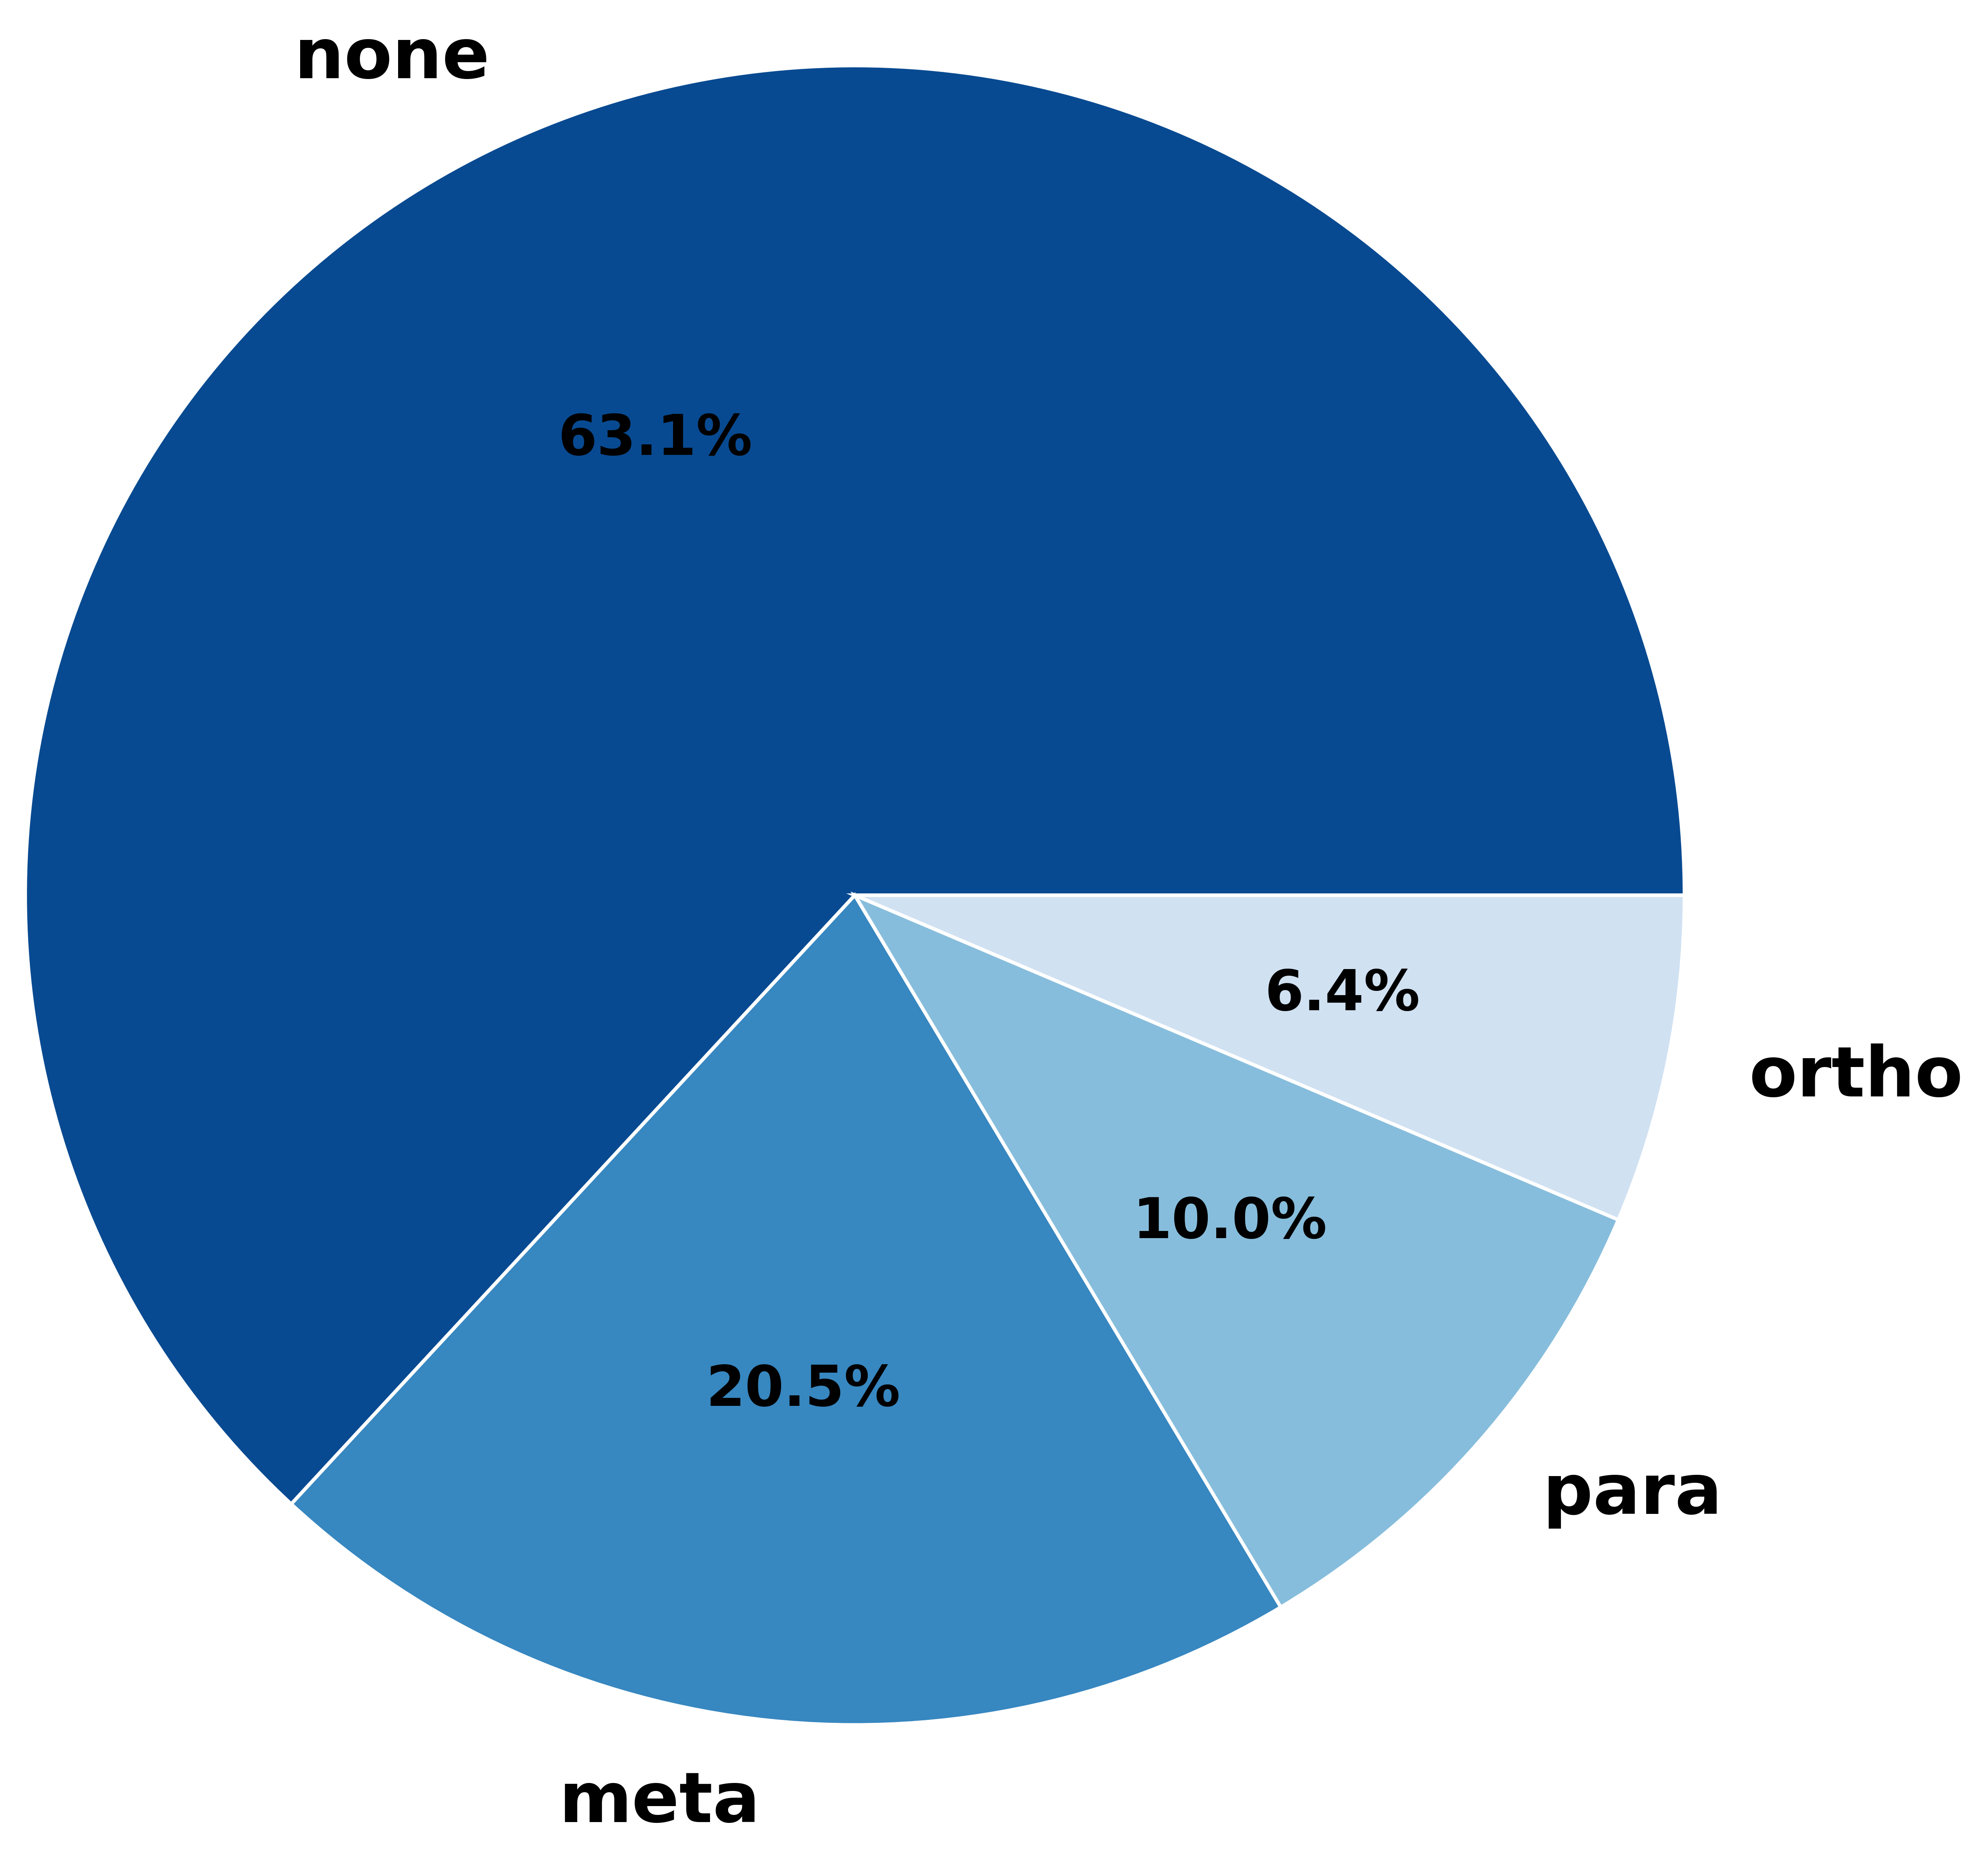

In [5]:
counts = df["selectivity"].value_counts()
labels = counts.index
sizes = counts.values


colors = plt.get_cmap('Blues')(np.linspace(0.9, 0.2, len(sizes)))
fig, ax = plt.subplots(figsize=(8,8),dpi=600)
patches, texts, autotexts = ax.pie(sizes, 
       labels=labels, 
       radius=2, 
       autopct='%1.1f%%', 
       shadow=False, 
       startangle=0, 
       colors=colors, 
       wedgeprops={"linewidth": 1, "edgecolor": "white"}
      )
for text in texts:
    text.set_fontsize(20)
    text.set_fontweight("bold")
    
for autotext in autotexts:
    autotext.set_fontsize(16)
    autotext.set_fontweight("bold")
    
plt.tight_layout(pad=-3.6)
plt.savefig("pie_chart.tif",dpi=600)
plt.show()

### 1.3. Converting the SMILES to Morgan Fingerprints

In [6]:
class Fingerprint:
    
    # This class is is equivalent to a data class which contains information about morgan fingerprint
    
    fingerprints = []
    
    def __init__(self, mol, bit_vector, on_bits, bit_info, include=True):
        self.mol = mol # molecule from which the fingerprint is generated
        self.bit_vector = bit_vector # bit vector
        self.on_bits = on_bits # set of indices in bit vector having a value of 1
        self.bit_info = bit_info # fragments encoded in the bits having value of 1
        
        if include:
            Fingerprint.fingerprints.append(self) # Keeps a record of each fingerprint created


class MorganFingerprint:
    
    # This class contains the parameters for Morgan fingerprints and featurize funtion
    
    mols = []
    
    def __init__(self, nbits:int, radius:int, features:bool, chirality:bool, include:bool):
        self.nbits = nbits
        self.radius = radius
        self.features = features
        self.chirality = chirality
        self.include = include
        
    def featurize(self, mol):
        MorganFingerprint.mols.append(mol)
        bit_info = {}
        fp = AllChem.GetMorganFingerprintAsBitVect(
                mol,
                self.radius,
                nBits = self.nbits,
                useFeatures = self.features,
                useChirality = self.chirality,
                bitInfo = bit_info
            )
        
        return Fingerprint(mol=mol,
                           bit_vector=np.array(fp),
                           on_bits=sorted(set(fp.GetOnBits())),
                           bit_info=bit_info,
                           include=self.include
                          )

In [7]:
def smiles_transformer(smiles_data, fingerprint_large_radius, fingerprint_small_radius):
    smiles_list = smiles_data.values
    mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
    X = []
    for mol in mols:
        fp_all_fragments = fingerprint_large_radius.featurize(mol).bit_vector.tolist()
        fp_smaller_fragments = fingerprint_small_radius.featurize(mol).bit_vector.tolist()
        
        smaller_fragment_indexes = []
        for i in range(len(fp_smaller_fragments)):
            if fp_smaller_fragments[i] == 1:
                smaller_fragment_indexes.append(i)
            i += 1
        
        for index in smaller_fragment_indexes:
            fp_all_fragments[index] = 0
            
        X.append(fp_all_fragments)
        
    return X

In [8]:
# Length of the bit vector.
NBITS = 1152

# Maximum radius of the Morgan Fragments to be featurized in the bit vector.
RADIUS = 2

In [9]:
morgan_fingerprint = MorganFingerprint(
    nbits=NBITS,
    radius=RADIUS,
    features=True,
    chirality=True,
    include=True
)

smaller_fragments_morgan_fingerprint = MorganFingerprint(
    nbits=NBITS,
    radius=RADIUS-1,
    features=True,
    chirality=True,
    include=False
)

In [10]:
X = smiles_transformer(df["smiles"], morgan_fingerprint, smaller_fragments_morgan_fingerprint)
y = df["selectivity"].values

### 1.4. Splitting the dataset

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## 2. Instiating and Validating the Model

1. Creating the model
2. Validating the model

### 2.1. Instantiating the model

Different machine learning models have different architecture, and uses different learning methods. Here we use the Logistic Regression model with l2 penalty.

For more information:

1. https://en.wikipedia.org/wiki/Logistic_regression
2. https://en.wikipedia.org/wiki/Multinomial_logistic_regression
3. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [12]:
model = LogisticRegression(penalty="l2")

### 2.2.  Validating the model (Cross-Validation)

The model was evaluated on how it performs on training data and testing data with varying sizes of training data.
This gives an idea on the generalizablity of the model. 

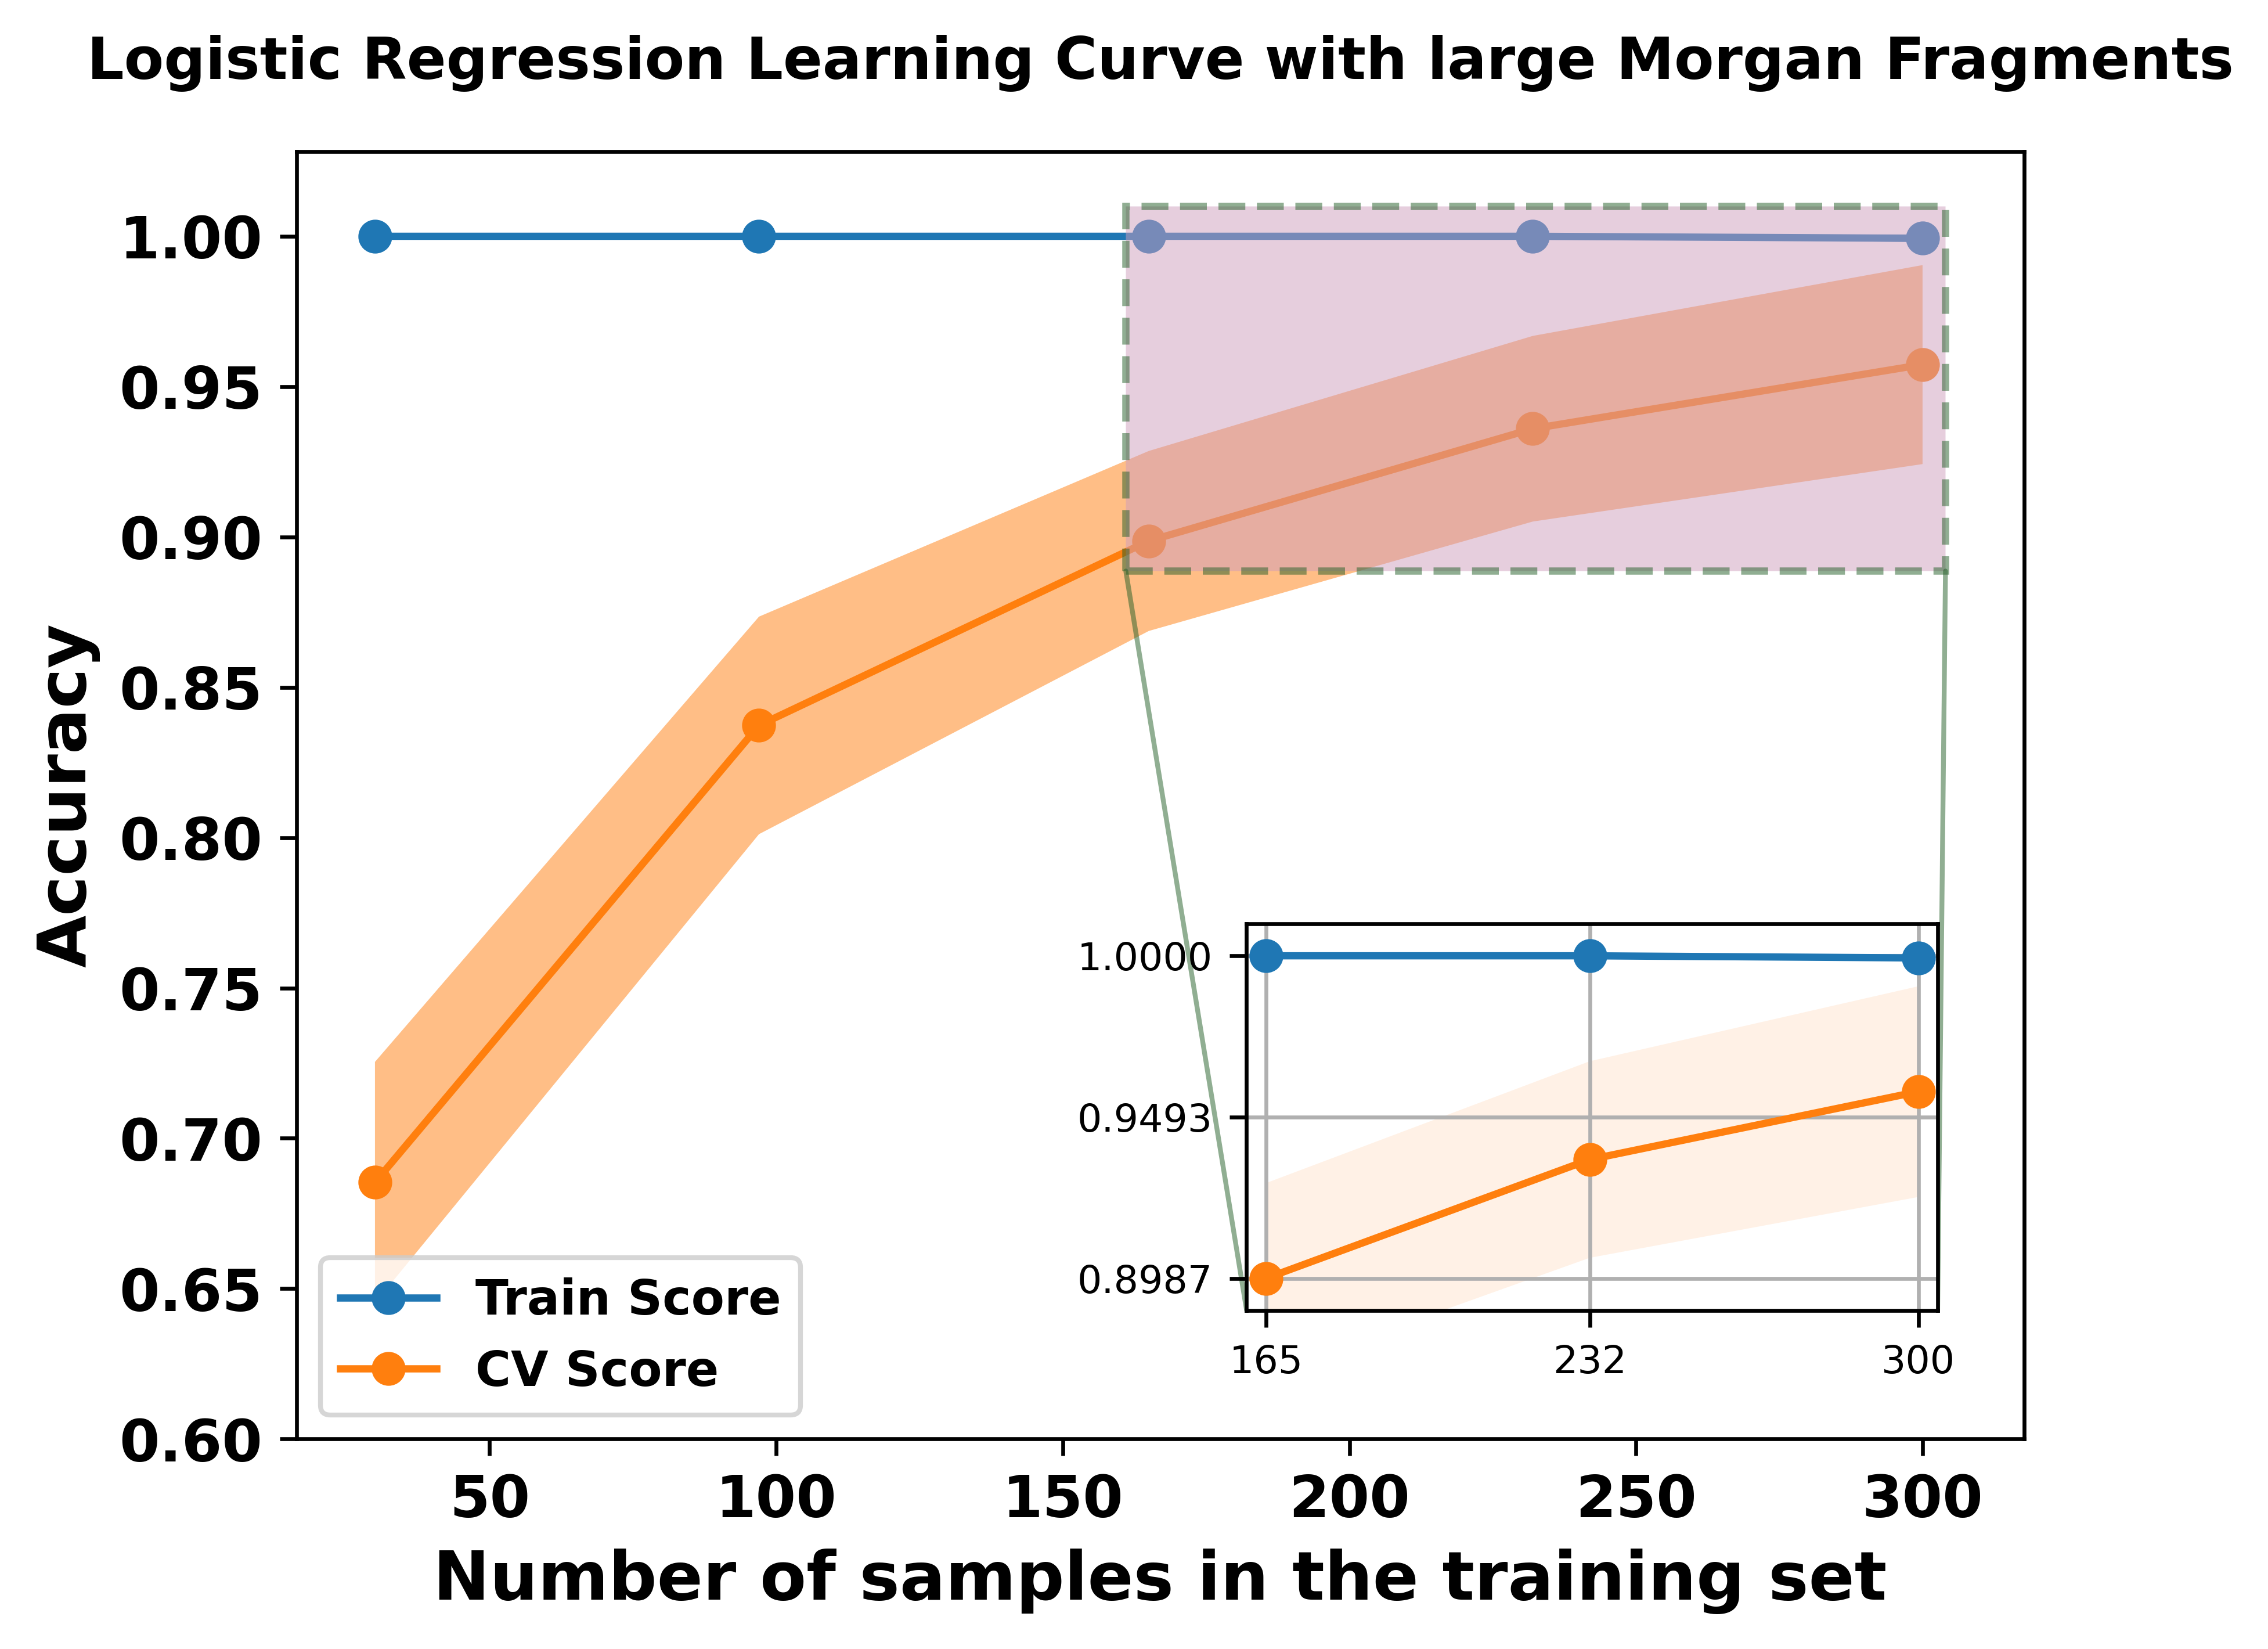

In [13]:
fig, ax = plt.subplots(dpi=600)

display = LearningCurveDisplay.from_estimator(estimator=model, 
                                    X=X_train, 
                                    y=y_train,
                                    train_sizes=np.linspace(0.1, 1.0, 5),
                                    cv=ShuffleSplit(n_splits=5, test_size=0.2, random_state=0),
                                    n_jobs=-1,
                                    line_kw={"marker": "o"},
                                    std_display_style="fill_between",
                                    score_name="Accuracy",
                                    ax=ax
                               )

train_sizes = display.train_sizes

train_scores = display.train_scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)

test_scores = display.test_scores
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

zm = ax.inset_axes([0.55, 0.1, 0.4, 0.3])
num_end_points=3

# Plot only the last two points on the inset plot
zm.plot(train_sizes[-num_end_points:], train_scores_mean[-num_end_points:], 'o-', label="Train Score")
zm.plot(train_sizes[-num_end_points:], test_scores_mean[-num_end_points:], 'o-', label="Cross-Validation Score")
zm.fill_between(train_sizes[-num_end_points:], train_scores_mean[-num_end_points:] - train_scores_std[-num_end_points:], 
                train_scores_mean[-num_end_points:] + train_scores_std[-num_end_points:], alpha=0.1)
zm.fill_between(train_sizes[-num_end_points:], test_scores_mean[-num_end_points:] - test_scores_std[-num_end_points:], 
                test_scores_mean[-num_end_points:] + test_scores_std[-num_end_points:], alpha=0.1)

# Set the limits and labels for the inset plot
padding = 0.01
zm.set_xlim([train_sizes[-num_end_points] - 4, train_sizes[-1] + 4])
zm.set_ylim([min(train_scores_mean[-num_end_points:].min(), test_scores_mean[-num_end_points:].min()) - padding, 
             max(train_scores_mean[-num_end_points:].max(), test_scores_mean[-num_end_points:].max()) + padding])
zm.set_xticks(train_sizes[-num_end_points:])
zm.set_yticks(np.linspace(zm.get_ylim()[0]+padding, zm.get_ylim()[1]-padding, 3))
zm.tick_params(axis='both', which='major', labelsize=8)
zm.grid(True)

# Formatting the main plot
ax.indicate_inset_zoom(inset_ax=zm, 
                       linestyle="--",
                       facecolor=(0.812, 0.62, 0.741), 
                       linewidth=1.5, 
                       edgecolor=(0.133, 0.369, 0.149)
                      )
plt.xticks(fontweight="bold", fontsize=12)
plt.yticks([i for i in np.arange(0.6, 1.01, 0.05)], fontweight="bold", fontsize=12)
plt.xlabel("Number of samples in the training set", fontweight="bold", fontsize=14)
plt.ylabel("Accuracy", fontweight="bold", fontsize=14)
plt.legend(["Train Score", "CV Score"], fontsize=10, prop={"weight":"bold"})
plt.title("Logistic Regression Learning Curve with large Morgan Fragments", 
          fontweight="bold", 
          fontsize=12,
          pad=15
         )
plt.savefig("learning_curve_large_fragment_logistic_regression.tif", dpi=600)

## 3. Training and testing the model

1. Model trained on the training data.
2. Model evaluated on the training data.
3. Model evaluated on the testing data.

### 3.1. Model trained on the training data

In [14]:
model.fit(X_train, y_train)

LogisticRegression()

### 3.2. Model evaluated on the training data

In [15]:
y_train_pred = model.predict(X_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

        meta       1.00      1.00      1.00        78
        none       1.00      1.00      1.00       235
       ortho       1.00      0.96      0.98        24
        para       1.00      1.00      1.00        38

    accuracy                           1.00       375
   macro avg       1.00      0.99      0.99       375
weighted avg       1.00      1.00      1.00       375



### 3.3. Model evaluated on testing data

In [16]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        meta       0.90      1.00      0.95        18
        none       1.00      0.97      0.98        61
       ortho       1.00      1.00      1.00         6
        para       1.00      1.00      1.00         9

    accuracy                           0.98        94
   macro avg       0.97      0.99      0.98        94
weighted avg       0.98      0.98      0.98        94



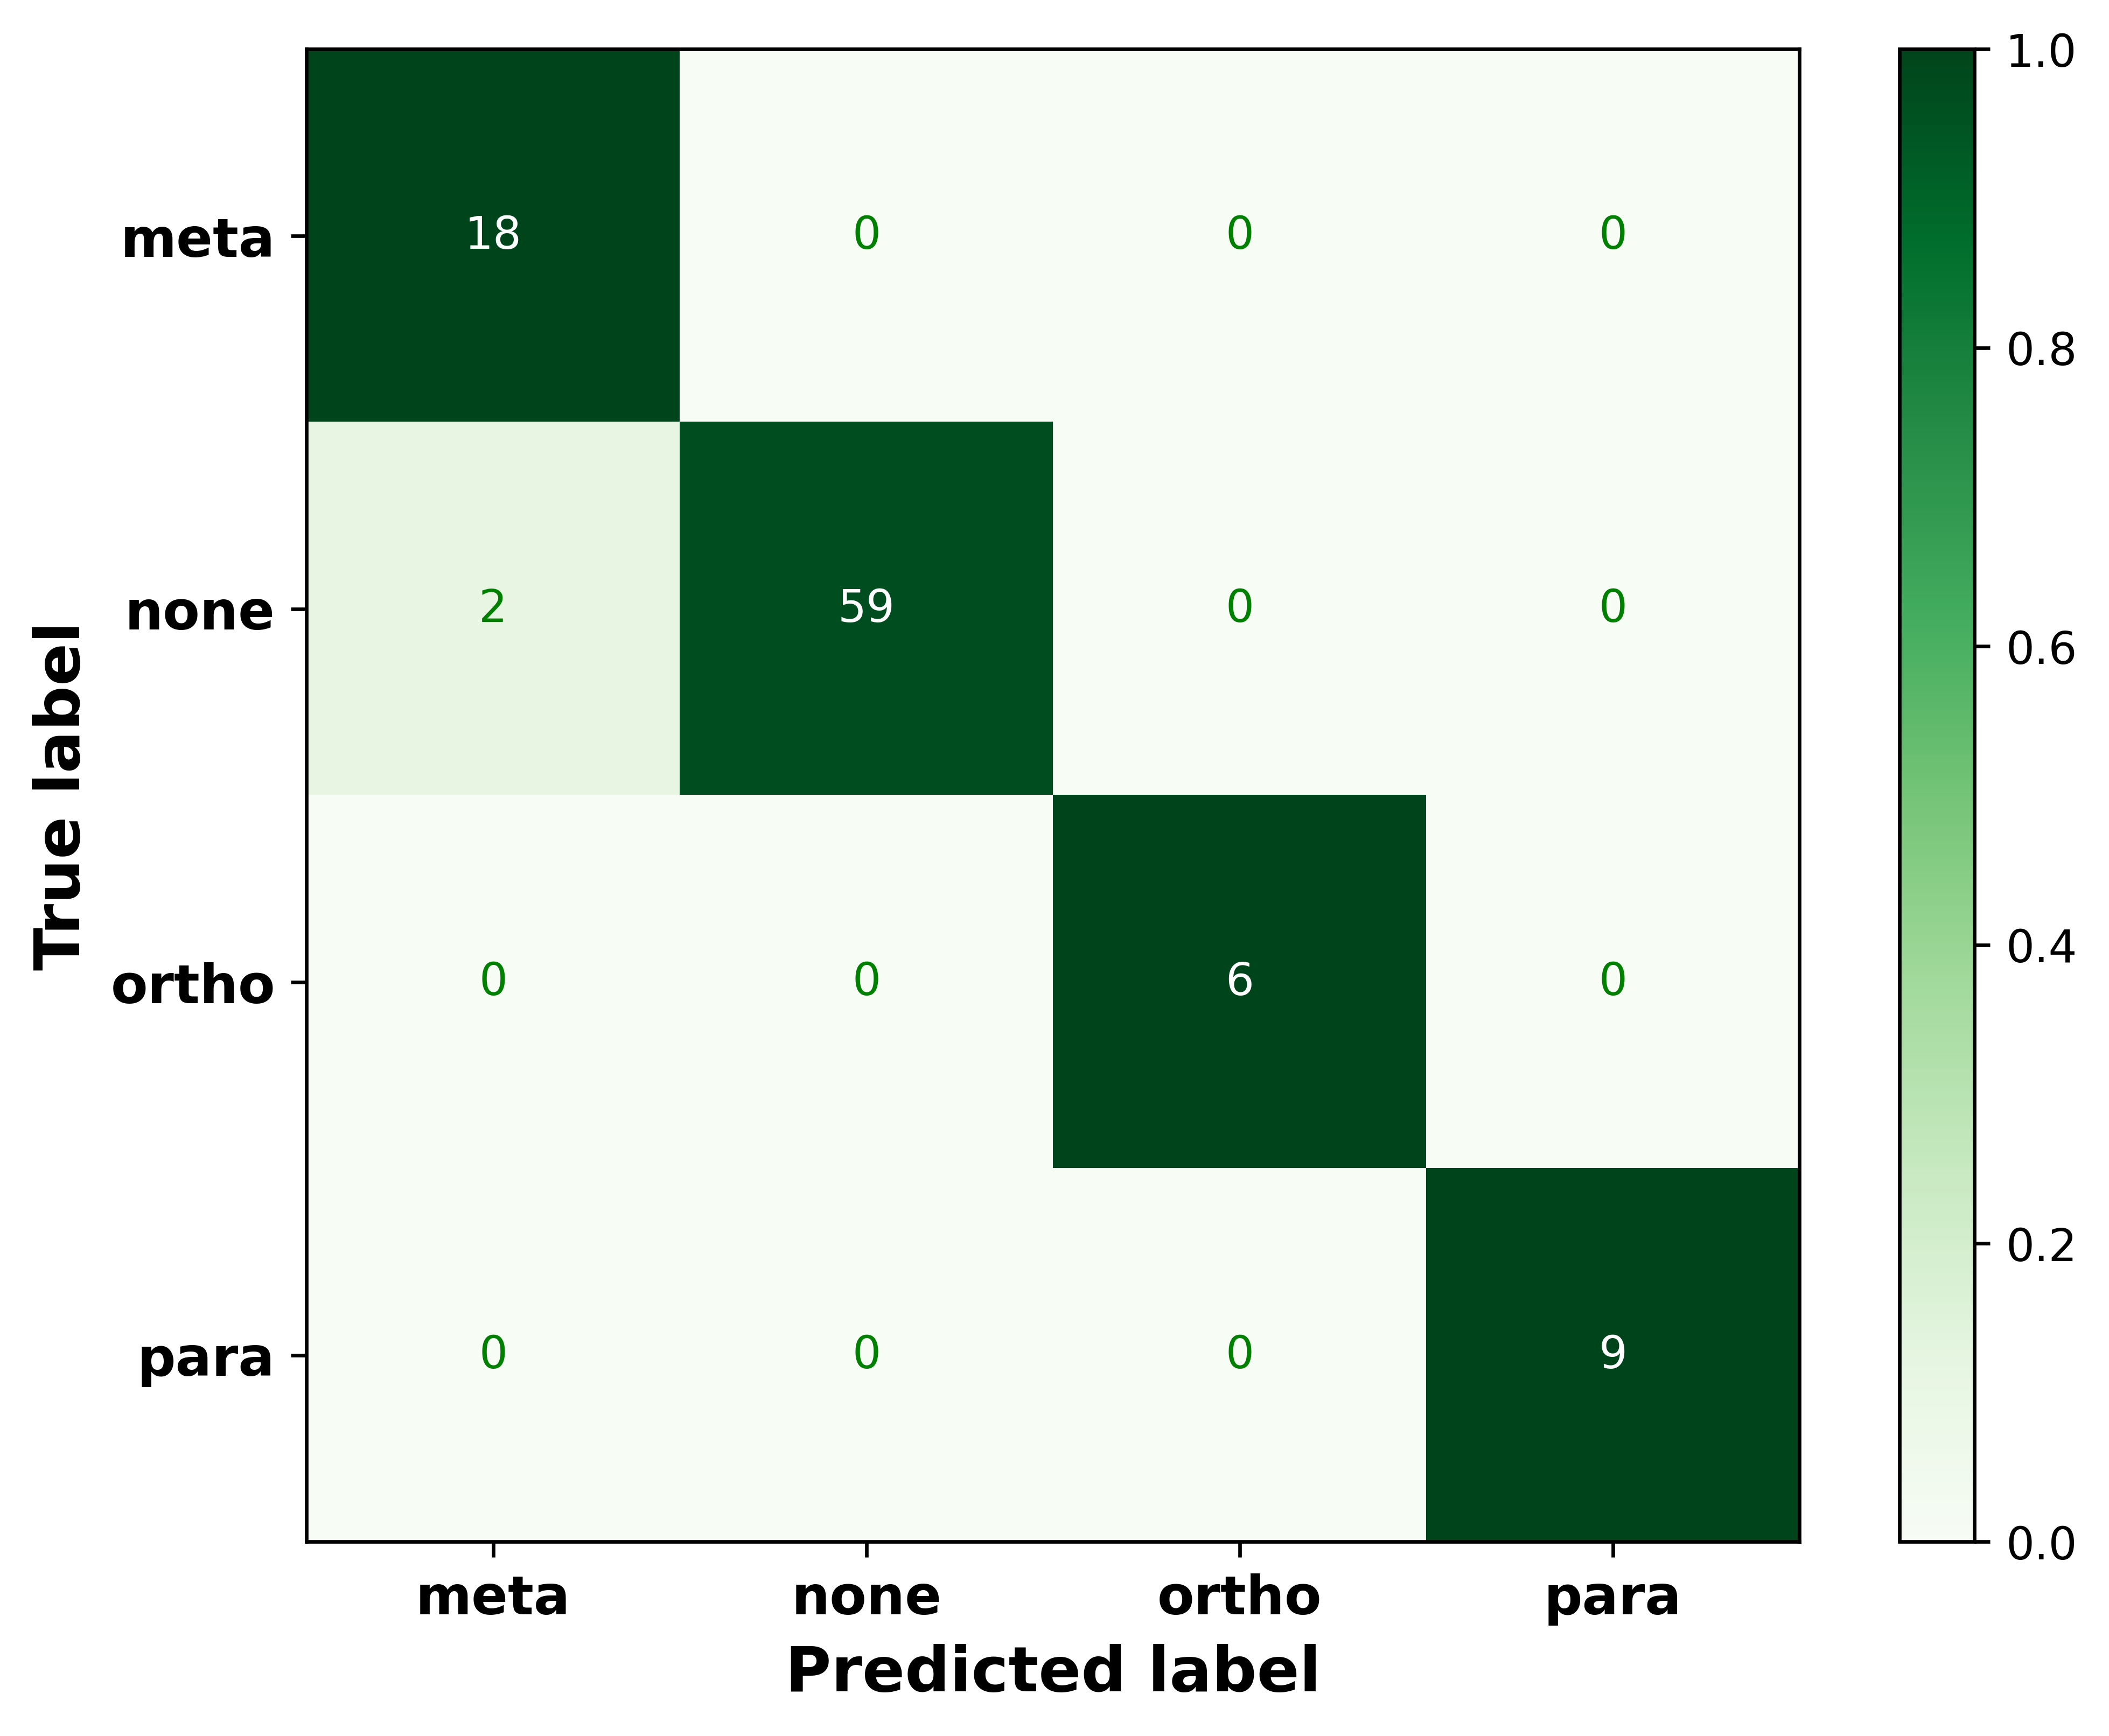

In [17]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

classes = model.classes_
accuracies = cm/cm.sum(1)
fig, ax = plt.subplots(figsize=(8,6), dpi=600)
cb = ax.imshow(accuracies, cmap='Greens')
plt.xticks(range(len(classes)), classes, rotation=0, fontweight="bold", fontsize=12)
plt.yticks(range(len(classes)), classes, fontweight="bold", fontsize=12)

for i in range(len(classes)):
    for j in range(len(classes)):
        color='green' if accuracies[i,j] < 0.5 else 'white'
        ax.annotate(f'{cm[j,i]}', (i,j), 
                    color=color, va='center', ha='center')

plt.colorbar(cb, ax=ax)
plt.xlabel("Predicted label", fontweight="bold", fontsize=14)
plt.ylabel("True label", fontweight="bold", fontsize=14)
plt.savefig("confusion_matrix_large_fragment_logistic_regression.tif", dpi=600)
plt.show()

In [18]:
def enumerate_and_sort(coef_array):
    '''
    This function takes a 2d array of values and returns another 2d array of dictionary
    the final array has 
    '''
    
    # Coeffecient array contains coeffecients assigned to each feature along columns for each class along rows
    # Shape : (number of classes, number of features)
    
    enumerated_list = []
    
    for class_coefs in coef_array:
        
        # class_coefs contains list of coeffecients assigned to corresponding features for a particular class.
        
        index_value_list = []
        index = 0
        
        for feature_coef in class_coefs:
            index_value = {'index': index, 'value': feature_coef}
            index_value_list.append(index_value)
            index += 1
        enumerated_list.append(index_value_list)
    
    for enumerated in enumerated_list:
        enumerated.sort(key=lambda index_value: abs(index_value['value']), reverse=True)
    
    return enumerated_list

In [19]:
def get_important_morgan_fragments(model, fingerprints:list, fragments_per_class):
    
    '''
    This function takes a scikit-learn machine learning model, a list, and
    an integer as arguments.
    
    model : scikit-learn model with coefs_ attribute
    fingerprints: a list of Fingeprint objects
    fragments_per_class: maximum number of important fragments whose information is to be extracted
    
    Returns an array of shape (number of classes, fragments_per_class)    
    '''
    
    # `model.coef_` returns an array of shape (number of classes, number of features)
    # The cells of the array contains coeffecient of a feature for the corresponding class.
    coef_array = model.coef_ 
    
    # getting a list of dictionaries containing feature index and coeffecient value arranged according
    sorted_coefs = enumerate_and_sort(coef_array)
    bit_infos = []
    all_on_bits = []
    for fingerprint in fingerprints:
        bit_infos.append(fingerprint.bit_info)
        all_on_bits.append(fingerprint.on_bits)
    
    imp_coefs = []
    for coef_list in sorted_coefs:
        imp_coefs.append(coef_list[:fragments_per_class])
    
    fragments_array = []
    legends_array = []
    
    for bit_list in imp_coefs:
        fragments = []
        legends = []
        for index_value in bit_list:
            index = index_value.get('index')
            index_found = False
            for fingerprint in fingerprints:
                if index in fingerprint.on_bits:
                    index_found = True
                    mol = fingerprint.mol
                    bit_info = fingerprint.bit_info
                    legends.append(f"bit: {index_value.get('index')} | value: {round(index_value.get('value'), 4)}")
                    fragments.append((mol, index, bit_info))
                    break
            if not index_found:
                print("Warning Bit not found")        
            
        fragments_array.append(fragments)
        legends_array.append(legends)
    return fragments_array, legends_array

In [20]:
fragments_array, legends_array = get_important_morgan_fragments(model, Fingerprint.fingerprints, 16)

para


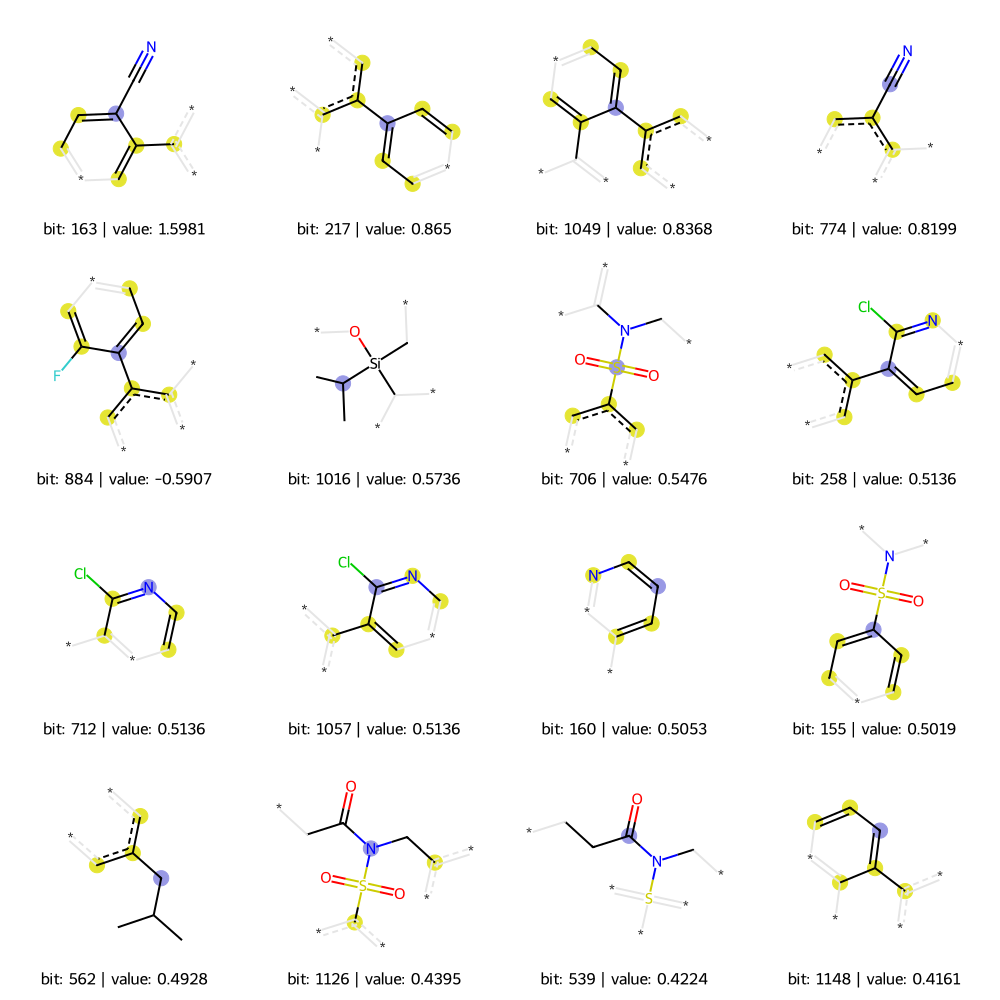

In [21]:
print(model.classes_[3])
Draw.DrawMorganBits(fragments_array[3][:100], 
                    legends=legends_array[3][:100], 
                    molsPerRow=4, 
                    useSVG=True, 
                    subImgSize=(250, 250),
                   )

In [22]:
for i in range(len(model.classes_)):
    with open(f'./{model.classes_[i]}_classifiers_large_fragment_logistic_regression.svg','wb+') as outfile:
         outfile.write(Draw.DrawMorganBits(fragments_array[i][:16], 
                                           legends=legends_array[i][:16], 
                                           molsPerRow=4, 
                                           useSVG=True, 
                                           subImgSize=(250, 250)).data.encode('utf-8'))